In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# вместо LinearRegression будем использовать Ridge
# это численно более стабильная модификация обычной линейной регрессии
from sklearn.linear_model import Ridge
# измерять качество предсказаний будем с помощью стандартной MSE
from sklearn.metrics import mean_squared_error
# для нормализации данных будем использовать MinMixScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
def visualize_coefficients(coefs, feature_names, top_n):
    """Функция для визуализации коэффициентов линейной регрессии.

    Параметры:
        coefs: коэффициенты модели (model.coef_).
        feature_names: названия признаков (X_train.columns).
        top_n: вывести top_n самых положительных и top_n самых отрицательных признаков.
    """
    feature_names = np.array(feature_names)
    if top_n * 2 > len(coefs):
        n_pos = len(coefs) // 2
        n_neg = len(coefs) - n_pos
    else:
        n_pos, n_neg = top_n, top_n
    # нам нужно найти индексы top_n наибольших и top_n наименьших коэффициентов
    min_coef_idxs = np.argsort(coefs)[:n_neg]
    max_coef_idxs = np.argsort(coefs)[len(coefs) - n_pos:]
    # соответствующие имена фичей
    top_feature_names = np.concatenate((feature_names[min_coef_idxs], feature_names[max_coef_idxs])) 
    # отобразим на bar-графике
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.bar(np.arange(n_neg), coefs[min_coef_idxs], color=sns.xkcd_rgb["mauve"], hatch="/")
    ax.bar(np.arange(n_neg, n_neg + n_pos), coefs[max_coef_idxs], color=sns.xkcd_rgb["teal"], hatch="\\")
    ax.set_xticks(np.arange(0, n_neg + n_pos))
    ax.set_xticklabels(top_feature_names, rotation=45, ha="right", fontsize=14)
    plt.show()

In [3]:
def visualize_preds(y_true, y_pred, n_hours=336):
    """Функция для визуализации таргета и предсказаний.

    Параметры:
        y_true: правильные ответы.
        y_pred: предсказания модели.
        n_hours: вывести на график заданное число точек с конца. По умолчанию 2 недели.

    """
    fig, ax = plt.subplots(figsize=(21, 9))
    index = y_true[-n_hours:].index
    ax.plot(index, y_true[-n_hours:], label="y_true")
    ax.plot(index, y_pred[-n_hours:], label="y_pred")
    ax.legend()
    plt.show()

# Загрузка данных

In [4]:
# parse_dates позволяет сразу распарсить даты в данных
# с помощью index_col указываем что будем использовать колонку с датой в качестве индекса датафрейма
train_df = pd.read_csv("indian-metro-train.csv", parse_dates=["date_time"], index_col="date_time")
val_df = pd.read_csv("indian-metro-val.csv", parse_dates=["date_time"], index_col="date_time")

In [5]:
train_df.head()

,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,temperature,rain_p_h,clouds_all,weather_type,weather_description,traffic_volume
date_time,,,,,,,,,,,,
2012-10-02 09:00:00,None,121,89,2,329,1,288.28,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,None,178,67,3,330,1,289.36,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,None,113,66,3,329,2,289.58,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,None,20,66,3,329,5,290.13,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,None,281,65,3,329,7,291.14,0.0,75,Clouds,broken clouds,4918


In [8]:
val_df.head()

,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,temperature,rain_p_h,clouds_all,weather_type,weather_description,traffic_volume
date_time,,,,,,,,,,,,
2015-06-11 20:00:00,None,282,65,3,327,5,287.586,0.0,92,Rain,light rain,2886
2015-06-12 18:00:00,None,84,65,3,325,6,297.543,0.0,0,Clear,Sky is Clear,4380
2015-06-12 20:00:00,None,97,63,3,323,2,292.061,0.0,8,Clear,sky is clear,3095
2015-06-12 21:00:00,None,29,63,2,320,5,292.061,0.0,8,Clear,sky is clear,3299
2015-06-13 21:00:00,None,78,68,3,322,3,294.840,0.0,76,Clouds,broken clouds,3040


Как видно, датафрейм содержит измерения количества людей в метро. Для каждого измерения доступна его дата и время (с разрешением до часа), а также набор признаков, описывающих ситуацию на момент измерения:


*   is_holiday: название праздника, если он проводится в этот день
*   air_pollution_index: индекс качества воздуха
*   humidity: относительная влажность в градусах Цельсия
*   wind_speed: скорость ветра в миль/ч
*   wind_direction: направление ветра в градусах
*   visibility_in_miles: видимость в милях
*   temperature: температура в Кельвинах
*   rain_p_h: количество выпавших осадков в мм за час
*   clouds_all
*   weather_type
*   weather_description: 
*   traffic_volume: количество людей, целевая переменная



Будем решать задачу предсказания traffic_volume по остальным признакам. Оценивать качество будем с помощью MSE на валидационной выборке. На семинаре также оценим ваши лучшие модели на отдельной тестовой выборке.

# Trainee

Попробуем обучить самую простую модель. Датасет содержит 3 нечисловых признака, с которыми придется отдельно придумать, что делать, поэтому просто исключим их (не забыв исключить и целевую переменную):

In [18]:
# рекомендую оформлять свой код подготовки данных в функции похожего вида
def prepare_data_trainee(train_df, val_df):
    X_train = train_df.drop(["is_holiday", "weather_type", "weather_description", "traffic_volume"], axis=1)
    X_val = val_df.drop(["is_holiday", "weather_type", "weather_description", "traffic_volume"], axis=1)
    # сохраним названия признаков для отрисовки графика
    feature_names = X_train.columns.tolist()

    y_train = train_df["traffic_volume"]
    y_val = val_df["traffic_volume"]

    # нормализуем данные для линейной регрессии
    scl = MinMaxScaler()
    X_train = scl.fit_transform(X_train)
    # !Важно: для train применяем метод .fit_transform(), для валидации и/или тест - .transform()
    X_val = scl.transform(X_val)
    return X_train, y_train, X_val, y_val, feature_names

In [19]:
X_train, y_train, X_val, y_val, feature_names = prepare_data_trainee(train_df, val_df)

In [20]:
# обучаем модель
model = Ridge()
model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)

train_mse = mean_squared_error(y_train, train_predictions)
val_mse = mean_squared_error(y_val, val_predictions)

print(f"Train MSE: {train_mse}")
print(f"Validation MSE: {val_mse}")

Train MSE: 3951770.018949029
Validation MSE: 3947564.7226819396


Модель успешно обучилась. Большой разницы между ошибкой на обучении и валидации не видно, значит как минимум модель пока что не переобучается :)

Давайте посмотрим как выглядит целевая переменная и предсказании на графике:

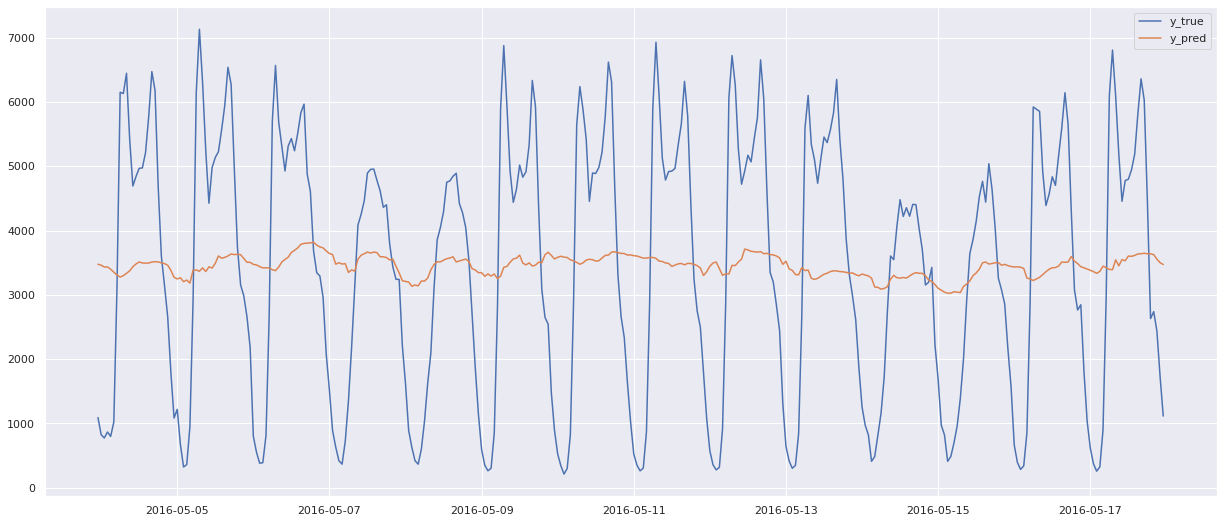

In [21]:
visualize_preds(y_val, val_predictions)

Модель явно слишком слабая - ей не хватает признаков, чтобы ухватить зависимость сложнее, чем предсказание около среднего.

Посмотрим также на влияние признаков:

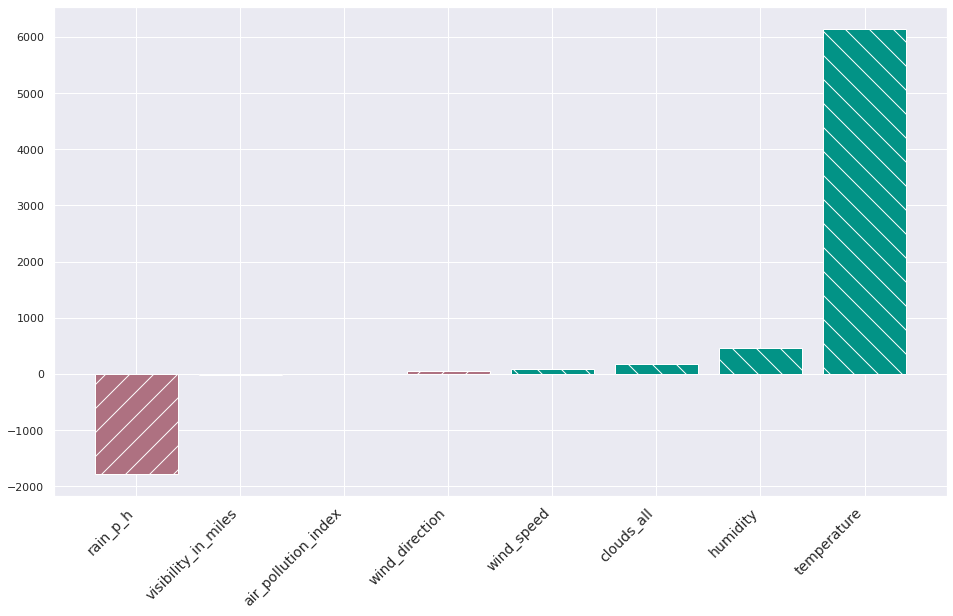

In [22]:
visualize_coefficients(model.coef_, feature_names, 15)

Забавно. Чем выше температура на улице - тем больше людей в метро по мнению модели, а чем больше осадков выпадало - тем меньше :)

# Задание

Как видно, в самом простом случае модель скорее не работает, чем работает. Для того, чтобы модель стала предсказывать лучше, необходимо придумать какие-то новые признаки, которые описывают влияние разных факторов на то, сколько людей спускается в метро. Подумайте, что может сильно влиять на этот процесс и как сообщить модели эти данные.

Подсказки:


*   Судя по графику процесс явно колебательный. Станет ли модели легче, если как-то сообщить ей о времени? (`?df.index.year`, `?df.index.month`, ...)
*   Ранее мы отбросили нечисловые признаки о праздниках и погоде. Можно ли попробовать как-то их закодировать? (`?pd.get_dummies`, `?sklearn.preprocessing.OneHotEncoder`)
*   Как вы думаете, если бы модель знала, сколько людей было в метро за час до этого - ей стало бы легче предсказывать? (`?pd.Series.shift`)
*   И любые другие идеи приветствуются :)
